In [1]:
import itertools
import os

import numpy as np
from functional import seq
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from dvals import games, values, player_distributions

In [2]:
torch.random.manual_seed(0)
np.random.seed(0)
# Load the MNIST training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Load the MNIST testing dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

# Define a DataLoader to handle batching and shuffling of the data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the LeNet-5 model architecture with 2 fully connected layers, very simple, no dropout etc. for simplicity
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(20 * 4 * 4, 200)
        self.fc2 = nn.Linear(200, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(-1, 20 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the modified LeNet-5 model
model = LeNet()

# Define the loss function (cross-entropy) and optimizer (stochastic gradient descent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Train
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished training; SAVING MODEL')
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/lenet5_weights.pth')

print('TESTING MODEL')
test_loader = DataLoader(test_dataset, batch_size=64)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

LOADING MODEL
TRAINING
[1] loss: 0.618
[2] loss: 0.101
[3] loss: 0.070
[4] loss: 0.056
[5] loss: 0.046
[6] loss: 0.039
[7] loss: 0.034
[8] loss: 0.030
[9] loss: 0.027
[10] loss: 0.023
[11] loss: 0.021
[12] loss: 0.019
[13] loss: 0.017
[14] loss: 0.015
[15] loss: 0.013
[16] loss: 0.012
[17] loss: 0.011
[18] loss: 0.010
[19] loss: 0.009
[20] loss: 0.008
[21] loss: 0.007
[22] loss: 0.006
[23] loss: 0.005
[24] loss: 0.004
[25] loss: 0.004
[26] loss: 0.004
[27] loss: 0.004
[28] loss: 0.004
[29] loss: 0.002
[30] loss: 0.002
Finished training; SAVING MODEL
TESTING MODEL
Accuracy of the network on the test images: 99.010000 %


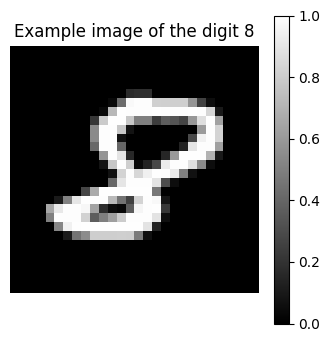

In [3]:
 # Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=torchvision.transforms.ToTensor())

# Find an example image of the digit 8
index = next(i for i, (image, label) in enumerate(test_dataset) if label == 8)

# Extract the image and label from the dataset
image, label = test_dataset[index]

# Convert the image to a NumPy array and plot it
def quick_show(img):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(4,4))
quick_show(image)
plt.title('Example image of the digit 8')
plt.axis('off')
plt.show()

In [4]:
# Define players as tuples with their coordinates
players = [(i, j) for i in range(28) for j in range(28)]
# Define payoff function
def payoff(S):  
    def mask_with(s):
        msk = torch.zeros_like(image)
        for i, j in s:
            msk[0, i, j] = 1.
        return msk

    masked_images = torch.cat(seq(S).map(lambda s: mask_with(s)*image.clone().detach()).list(), dim=0)
    with torch.no_grad():
        return model(masked_images.unsqueeze(1)).detach().cpu().numpy()

In [5]:
# permutation distribution for the Shapley value with the players
apd = player_distributions.PermutationDistribution.shapley(players)

Overflow error, use only sample!


In [6]:
# Define the "standard games" and the categorical game
game = games.Game(payoff)
cat_game = games.CategoricalGame.from_logits_game(game)

In [7]:
# Test the categorical game
c = cat_game([{}, set(players)])
c

array([<CategoricalPayoff {0: 0.08296011, 1: 0.10391814, 2: 0.113111295, 3: 0.12968326, 4: 0.07282299, 5: 0.13128577, 6: 0.08057618, 7: 0.08634154, 8: 0.10046796, 9: 0.09883281}>,
       <CategoricalPayoff {0: 1.628984e-16, 1: 8.116071e-21, 2: 4.9942392e-09, 3: 2.8976722e-11, 4: 1.2199037e-16, 5: 2.155843e-13, 6: 1.7826835e-14, 7: 1.9706929e-18, 8: 1.0, 9: 4.903502e-13}>],
      dtype=object)

In [8]:
# compute the categorical values (use accelerators if available!) 
vals = values.estimate(cat_game, apd, n_samples=1000, progress_bar=True)

100%|██████████| 1000/1000 [20:57<00:00,  1.26s/it]


In [9]:
ent = np.zeros_like(image)  # entropy matrix
for (i, j), v in vals.items():
    ent[0, i, j] = v.entropy()

def get_me(what):  
    # construct an image containing the transition probability specified by what [should be a tuple <- (to, from))]
    probs = np.zeros_like(image)
    for (i, j), v in vals.items():
        probs[0, i, j] = v[what]
    return probs/1000

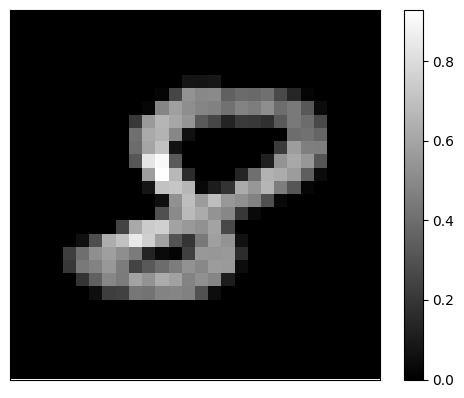

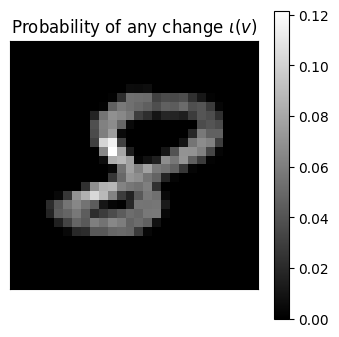

In [10]:
quick_show(ent)
plt.show()
plt.figure(figsize=(4,4))
plt.title("Probability of any change $\iota(v)$")
quick_show(1 - get_me(0))

Text(0.5, 1.0, '5 -> 3')

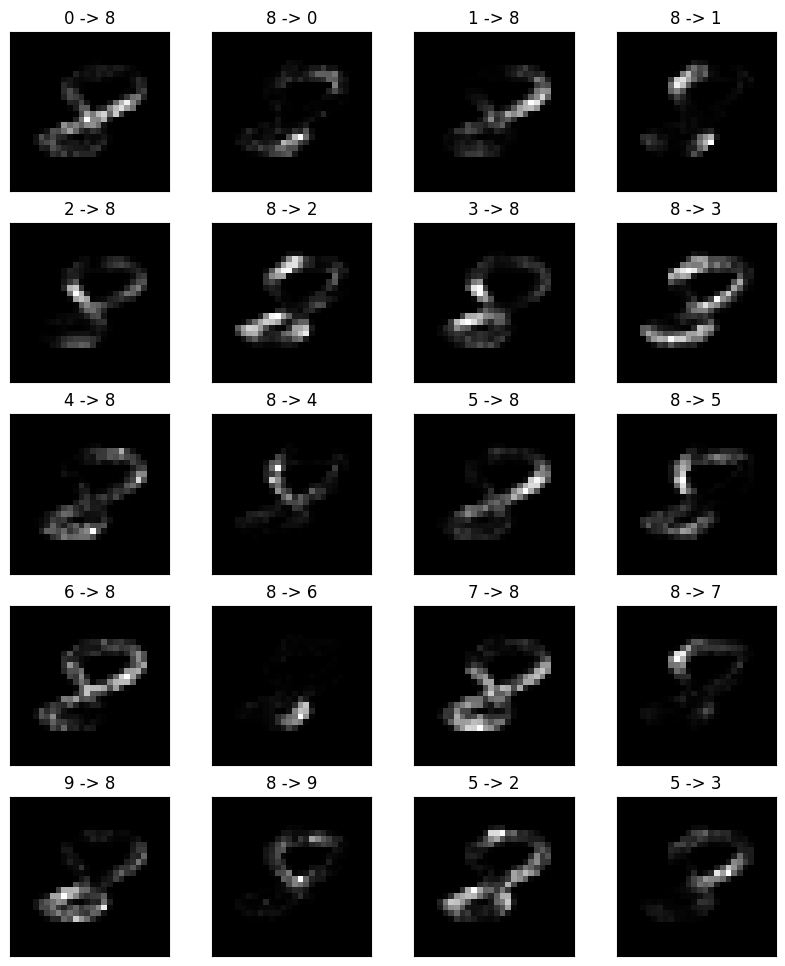

In [11]:
# Make a table of plots with various transition probabilities
to_add = {}
for i in range(10):
    if i != 8:
        to_add[f'{i} -> 8'] = get_me((8, i))
        to_add[f'8 -> {i}'] = get_me((i, 8))

fig, ax = plt.subplots(5, 4, figsize=(2.5*4, 2*6))
ax = np.reshape(ax, [-1])
for a, (k, v) in zip(ax, to_add.items()):
    a.imshow(v.squeeze(), cmap='gray')
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(k)
a = ax[-2]
v = get_me((2, 5))
a.imshow(v.squeeze(), cmap='gray')
a.set_xticks([])
a.set_yticks([])
a.set_title(f'5 -> 2')

a = ax[-1]
v = get_me((3, 5))
a.imshow(v.squeeze(), cmap='gray')
a.set_xticks([])
a.set_yticks([])
a.set_title(f'5 -> 3')

In [12]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-5., vcenter=0., vmax=10)

In [13]:
def get_me_exp(what):  # creates an "image" of the Shapley value
    probs = np.zeros_like(image)
    for (i, j), v in vals.items():
        probs[0, i, j] = v.expected_value()[what]
    return probs

# computes the standard Shapley value (as the expectation of the categorical values)
shapv = []
for i in range(10):
    shapv.append(get_me_exp(i))

In [14]:
def do_two_slope_img_plot(what, axes, title=''):
    nrm = colors.TwoSlopeNorm(vmin=min(v.min(), 0), vcenter=0.,
                              vmax=max(v.max(), 0))
    axes.imshow(what.squeeze(), cmap='coolwarm', norm=nrm)
    axes.set_title(title)
    axes.set_xticks([])
    axes.set_yticks([])
    # plt.show()

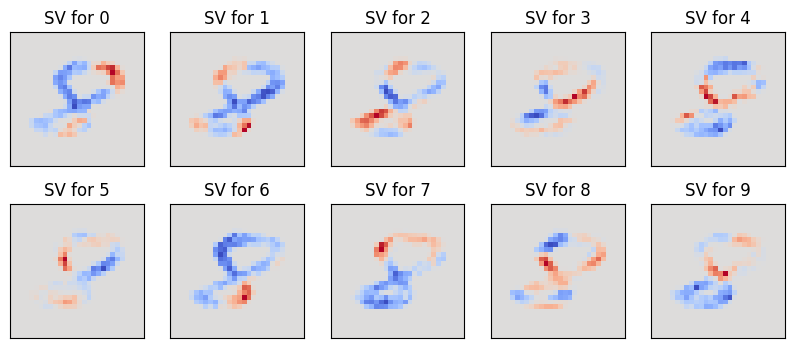

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4.1))

ax = ax.reshape([-1])
for k, (a, v) in enumerate(zip(ax, shapv)):
    do_two_slope_img_plot(v, a, f"SV for {k}")

In [16]:
# Variance
def get_me_var(c1, c2):  # essentially creates an "image" of the Shapley value
    probs = np.zeros_like(image)
    for (i, j), v in vals.items():
        probs[0, i, j] = v.variance()[c1, c2]
    return probs


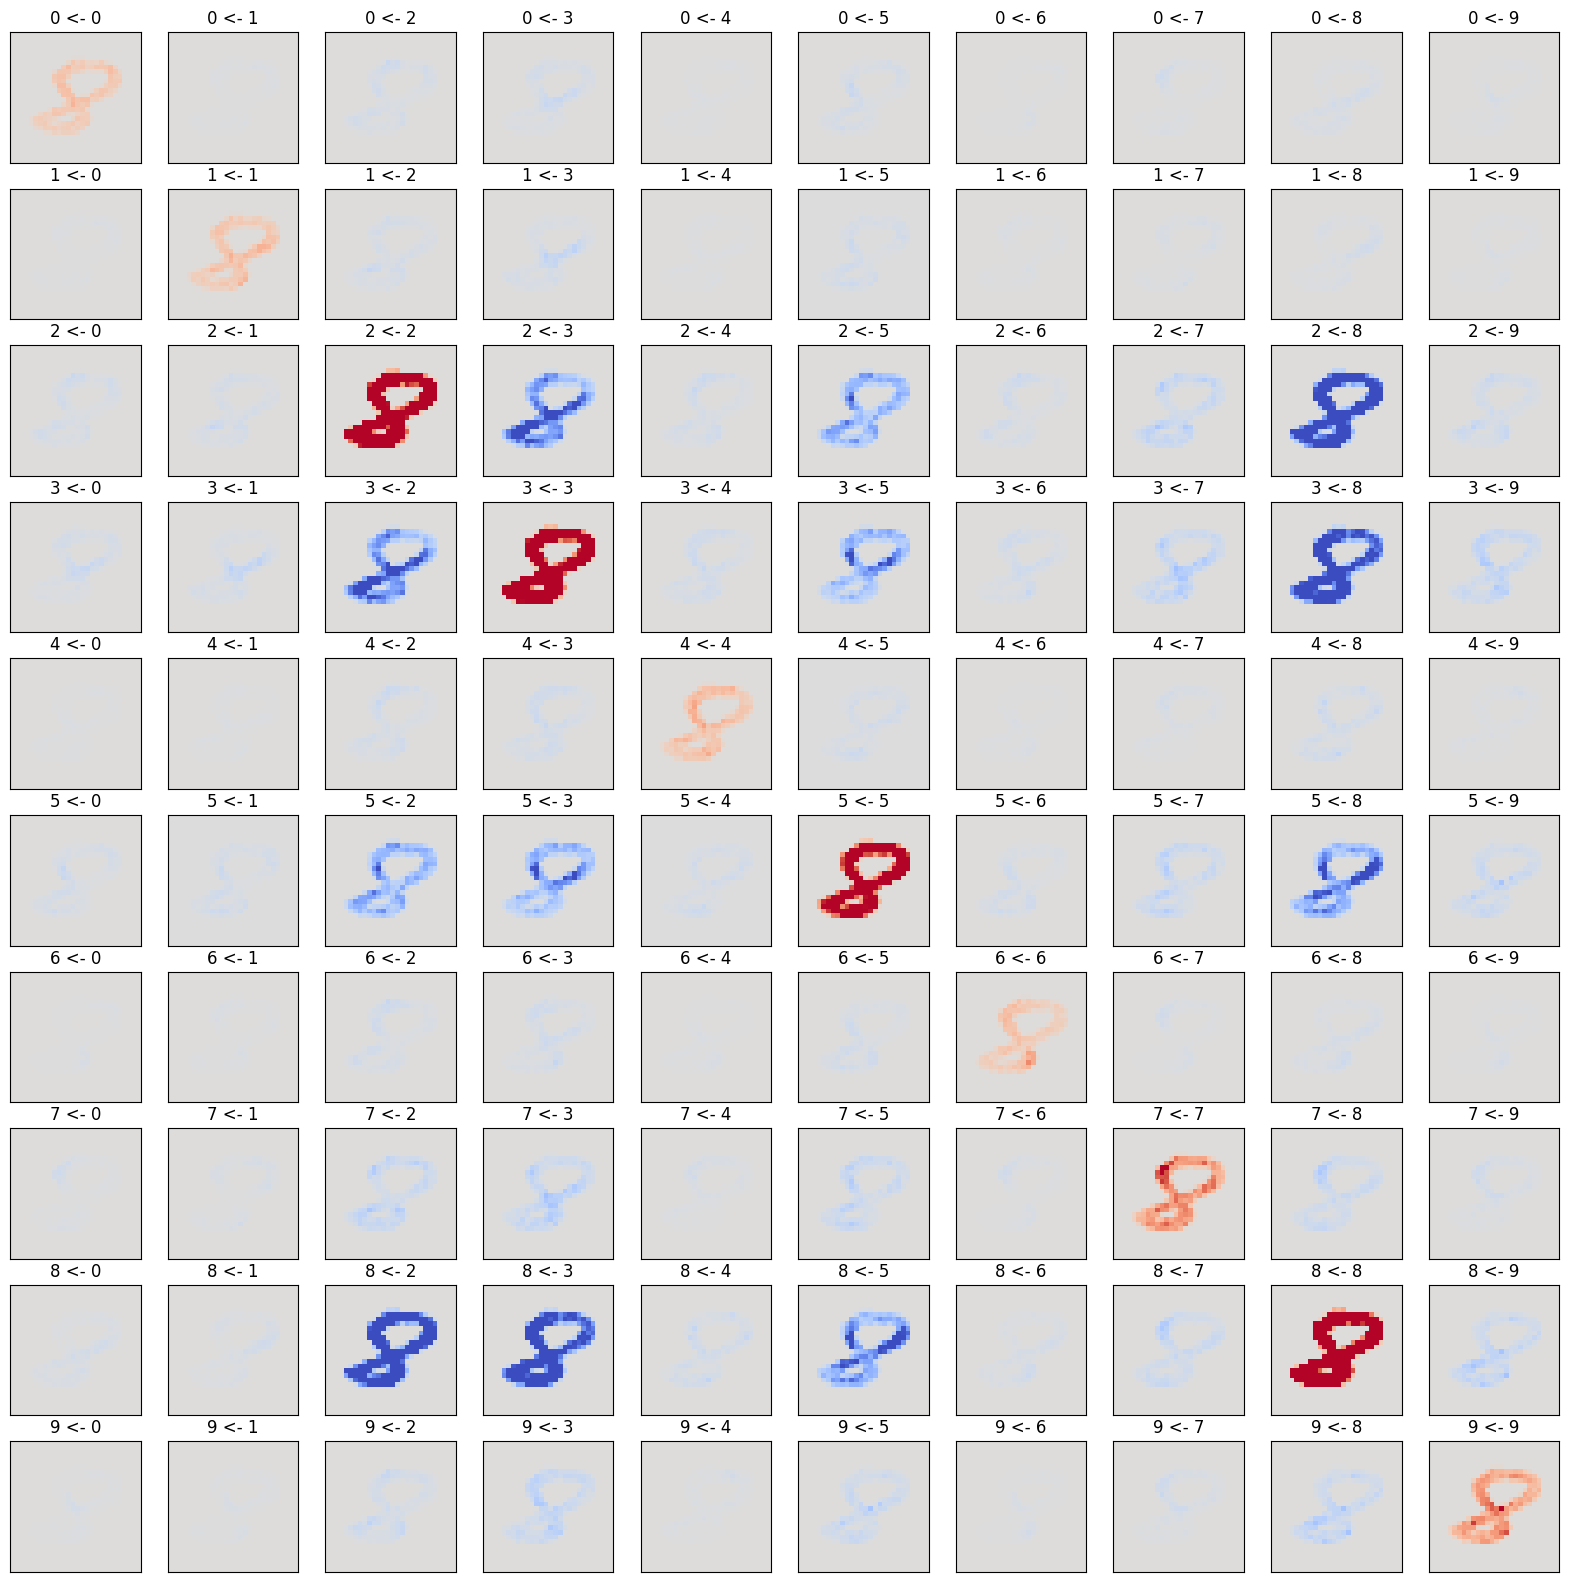

In [17]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.flatten()

ax = ax.reshape([-1])
for a, (i, j) in zip(ax, itertools.product(range(10), repeat=2)):
    vr = get_me_var(i, j)
    do_two_slope_img_plot(vr, a, f"{i} <- {j}")

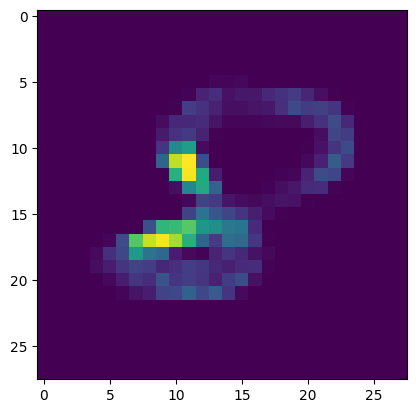

In [18]:
# Let's see what happens in the path 3 - 8 to investigate the contrastive power of distributional values
plt.imshow(get_me((8, 3)).squeeze())

In [19]:
def get_maximising_path(one_class): 
    other_classes = list(range(10))
    all_trans_prob = []
    for i in other_classes:
        if i !=one_class:
            all_trans_prob.append(get_me((i, one_class)))
    all_trans_prob = np.array(all_trans_prob)
    return np.max(all_trans_prob, axis=0)

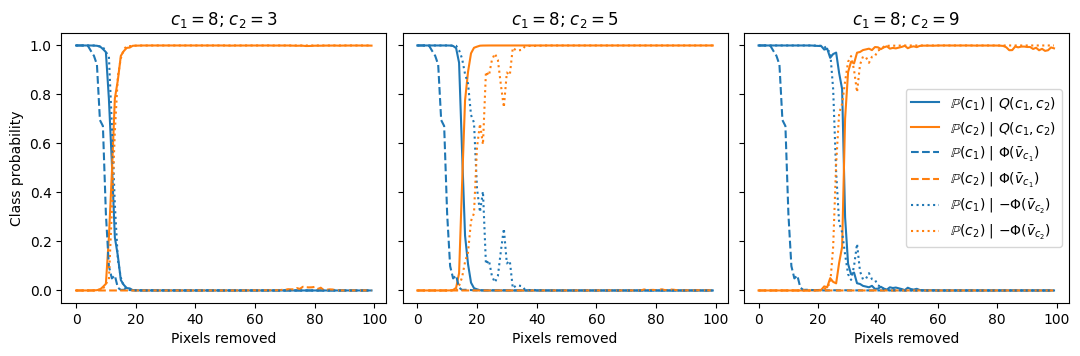

In [20]:
def obtain_modified_images(values):
    sorting_indices = np.argsort(-values, axis=None)
    mod_images = [image]
    for index in sorting_indices:
        row_index = index // image.shape[-1]
        col_index = index % image.shape[-1]

        cimage = mod_images[-1].clone().detach()
        cimage[0, row_index, col_index] = 0.
        mod_images.append(cimage)
    return torch.stack(mod_images)

limit_to = 100
cls1s = [8, 8, 8]
cls2s = [3, 5, 9]
fig, ax = plt.subplots(ncols=3, figsize=(13, 3.5), sharey=True, gridspec_kw={'wspace': 0.05})
do_y = True
for cls1, cls2, a in zip(cls1s, cls2s, ax):
    max_path = obtain_modified_images(get_maximising_path(cls2))
    md_imgs_8_3 = obtain_modified_images(get_me((cls1, cls2)))
    md_im_with_sv = obtain_modified_images(shapv[cls1])
    md_im_with_sv3 = obtain_modified_images(-shapv[cls2])

    with torch.no_grad():
        pred_max = torch.softmax(model(max_path[:limit_to]), dim=1)
        pred_mod_images = torch.softmax(model(md_imgs_8_3[:limit_to]), dim=1)
        pred_mod_images_sv = torch.softmax(model(md_im_with_sv[:limit_to]), dim=1)
        pred_mod_images_sv3 = torch.softmax(model(md_im_with_sv3[:limit_to]), dim=1)

    a.plot(pred_mod_images[:, cls1],            label=r'$\mathbb{P}(c_1)$ | $Q(c_1, c_2)$', color='C0')
    a.plot(pred_mod_images[:, cls2],            label=r'$\mathbb{P}(c_2)$ | $Q(c_1, c_2)$', color='C1')
    a.plot(pred_mod_images_sv[:, cls1], '--',   label=r'$\mathbb{P}(c_1)$ | $\Phi(\bar{v}_{c_1})$', color='C0')
    a.plot(pred_mod_images_sv[:, cls2], '--',   label=r'$\mathbb{P}(c_2)$ | $\Phi(\bar{v}_{c_1})$', color='C1')
    a.plot(pred_mod_images_sv3[:, cls1], ':',   label=r'$\mathbb{P}(c_1)$ | $-\Phi(\bar{v}_{c_2})$', color='C0')
    a.plot(pred_mod_images_sv3[:, cls2], ':',   label=r'$\mathbb{P}(c_2)$ | $-\Phi(\bar{v}_{c_2})$', color='C1')
    a.set_title(rf"$c_1=${cls1}; $c_2=${cls2}")

    if a == ax[0]:
        a.set_ylabel("Class probability")
    if a == ax[-1]:
        a.legend(loc=0)
    a.set_xlabel("Pixels removed")


In [20]:
# see section D.3 for details